<a href="https://colab.research.google.com/github/AndrewCrossman/PHYS824/blob/main/Phys824_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conductance and Shot Noise of Pseudodiffusive and Diffusive Electron Transport Through Graphene Nanoribbons
### © Andrew Crossman, University of Delaware
[PHYS824: Nanophysics & Nanotechnology](https://wiki.physics.udel.edu/phys824) 

In [ ]:
pip install kwant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
  Created wheel for kwant: filename=kwant-1.4.3-cp38-cp38-linux_x86_64.whl size=4293459 sha256=a82979c6a3690a341e43597fdea663b37ace65722e42202be38040d117f00d4b
  Stored in directory: /root/.cache/pip/wheels/6f/df/9e/c539998ebc40515fff5ab4a3254a8defafa218f89848e47de8
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp38-cp38-linux_x86_64.whl size=231196 sha256=133cc6a99bd313706e332fbd127b4c30bb13e55207815c31c2aa02b7a1ebac1e
  Stored in directory: /root/.cache/pip/wheels/60/fc/af/bd51765e167af783d7211176ba6da429472161b2462d4d5bc6
Successfully built kwant tinyarray


In [ ]:
# Imports
import numpy as np
import kwant 
from kwant.builder import HoppingKind 
from numpy.random import rand
from functools import reduce
import scipy.linalg as la
import math
from math import sqrt
from numpy import arange
import random
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [ ]:
# If using Google Colab Include
from google.colab import files

## Part I: Semi-infinite ZGNR with Leads

Define function to compute conductance, conductivity, and fanofactor of ZGNR with a given width, length, 1st NN hopping, gate voltage, and energy.

In [ ]:
def Q1(width, length, t, gate, energy):
  graphene = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                 [[0, 0], [0, 1/np.sqrt(3)]])  # Coordinates of the sites
  a, b = graphene.sublattices
  gr_lat = kwant.lattice.honeycomb(a=2.46)
  v1, v2 = gr_lat.prim_vecs 
  # Make graphene ribbon
  sys = kwant.Builder()
  sys[gr_lat.shape((lambda pos: abs(pos[0])<0.5*length and abs(pos[1])<0.5*width), (0, 0))] = gate
  sys[gr_lat.neighbors(1)] = t
  # Make leads
  left_direction = kwant.TranslationalSymmetry(-v1)
  left_lead = kwant.Builder(left_direction)
  left_lead[gr_lat.shape( (lambda pos: abs(pos[1])<0.5*width), (0, 0))] = 0
  left_lead[gr_lat.neighbors()] = t
  # Attach leads
  sys.attach_lead(left_lead)
  sys.attach_lead(left_lead.reversed())
  kwant.plot(sys, dpi=100);
  # Finalize systems
  sys = sys.finalized()
  left_lead = left_lead.finalized()

  smatrix = kwant.smatrix(sys, energy) 
  tmat = smatrix.submatrix(1, 0) # transmission from lead 0->1
  tt = np.dot(tmat, tmat.conj().T)
  evals = np.linalg.eigvals(tt)
  num = 0
  den = 0
  for x in evals:
    den = den + x
    num = num + x*(1-x)
  conductance = den.real # from lead 0->1
  fanofactor = (num/den).real
  conductivity = conductance * length/width
  shot_noise = num # formula from wikipedia
  return conductance, conductivity, fanofactor, shot_noise

<Monatomic lattice 0> <Monatomic lattice 1>


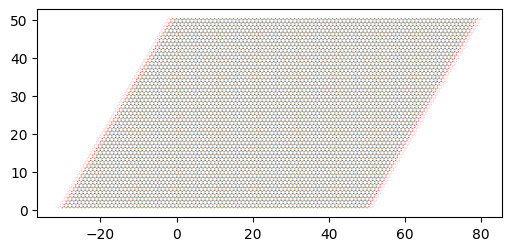

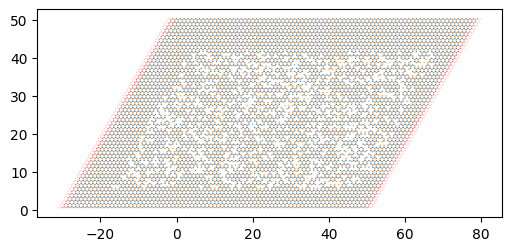

In [ ]:
length = 50
width = 50.5
graphene = kwant.lattice.general([(1,0),(1/2,sqrt(3)/2)], [(0,0),(0,1/sqrt(3))])
a,b = graphene.sublattices
print(a,b)
sys = kwant.Builder()
sys[graphene.shape((lambda pos: 0<=pos[0]<length and 0<pos[1]<width), (0, 0))] = 0
sys[graphene.neighbors(1)] = -1
# Make leads
left_direction = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
left_lead = kwant.Builder(left_direction)
left_lead[graphene.shape( (lambda pos: 0<pos[1]<width), (0, 0))] = 0.0
left_lead[graphene.neighbors()] = -1
# Attach leads
sys.attach_lead(left_lead)
sys.attach_lead(left_lead.reversed())
# Count Total Number of Sites
num_sites = len(sys.finalized().sites)
# Remove vac % of sites from Central Region
kwant.plot(sys, dpi=100);

num_sites = len(sys.finalized().sites)
# Remove vac % of sites from Central Region
h=0
tries = 0
while h<num_sites*.1:
  if tries>num_sites*.1*3:
      break
  try:
    tries = tries + 1
    i = random.randint(-int(.4*width),int(.9*length))
    j = random.randint(int(.15*width),int(.95*width))
    del sys[a(i,j)]
    h=h+1
  except KeyError:
    continue
  #except ValueError:
  #  continue
  try:
    tries = tries + 1
    i = random.randint(-int(.4*width),int(.9*length))
    j = random.randint(int(.15*width),int(.95*width))
    del sys[b(i,j)]
    h=h+1
  except KeyError:
    continue
  except ValueError:
    continue
  # Finalize system
sys = sys.finalized()
  # Plot ZGNR Image
kwant.plot(sys, dpi=100);

Find and plot the conductances, conductivities, and fanofactors for a variety of widths and lengths with t=-3, gate voltage = .5eV and energy=.505eV. (Reproduce Fig. 5)

In [ ]:
Widths = [50,100,150,200,250]
Lengths = np.linspace(5, 150, num=50, endpoint=True)
conductances = {}
conductivities = {}
fanofactors = {}
shot_noises = {}

t0 = -3
gate0 = 0.5
energy0 = 0.505

for W in Widths:
  Gs = []
  cs = []
  ffs = []
  sns = []
  for L in Lengths:
    print(W,L)
    a = Q1(W, L, t0, gate0, energy0)
    Gs.append(a[0])
    cs.append(a[1])
    ffs.append(a[2])
    sns.append(a[3])
  conductances[W] = Gs
  conductivities[W] = cs
  fanofactors[W] = ffs
  shot_noises[W] = sns

fig1, ax1 = plt.subplots(dpi=100, figsize=(6,4))
fig2, ax2 = plt.subplots(dpi=100, figsize=(6,4))
fig3, ax3 = plt.subplots(dpi=100, figsize=(6,4))
fig4, ax4 = plt.subplots(dpi=100, figsize=(6,4))
for key in conductances.keys():
  ax1.plot(Lengths, conductances[key], label='W'+str(key))
  ax2.plot(Lengths, conductivities[key], label='W'+str(key))
  ax3.plot(Lengths, fanofactors[key], label='W'+str(key))
  ax4.plot(Lengths, shot_noises[key], label='W'+str(key))

ax1.set_title('Conductances', fontsize=14, fontweight='bold')
ax1.set_xlabel(r'L $(\AA)$', fontsize=14, fontweight='bold')
ax1.set_ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=14)
ax1.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig1.savefig('Conductances_Q1_5.png')
files.download('Conductances_Q1_5.png')

ax2.set_title('Conductivities', fontsize=14, fontweight='bold')
ax2.set_xlabel(r'L $(\AA)$', fontsize=14, fontweight='bold')
ax2.set_ylabel(r'$\sigma$ ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=14)
ax2.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig2.savefig('Conductivities_Q1_5.png')
files.download('Conductivities_Q1_5.png')

ax3.set_title('Fano Factors', fontsize=14, fontweight='bold')
ax3.set_xlabel(r'L $(\AA)$', fontsize=14, fontweight='bold')
ax3.set_ylabel(r'F', fontsize=14, fontweight='bold')
ax3.legend(fontsize=14)
ax3.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig3.savefig('Fanofactors_Q1_5.png')
files.download('Fanofactors_Q1_5.png')

ax4.set_title('Shot Noises', fontsize=14, fontweight='bold')
ax4.set_xlabel(r'L $(\AA)$', fontsize=14, fontweight='bold')
ax4.set_ylabel(r'Shot Noise ($\frac{4e^3}{h}$)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=14)
ax4.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig4.savefig('Shot_Noises_Q1_5.png')
files.download('Shot_Noises_Q1_5.png')

Find and plot the conductances, conductivities, and fanofactors for a variety of widths and lengths with t=-3, gate voltage = .5eV and energy=.501eV. (Reproduce Fig. 6)

In [ ]:
Widths = [50,100,150,200,250]
L_over_W =  np.linspace(.05, 1, num=50, endpoint=True)
conductances = {}
conductivities = {}
fanofactors = {}
shot_noises = {}

t0 = -3
gate0 = 0.5
energy0 = 0.501

for W in Widths:
  Gs = []
  cs = []
  ffs = []
  sns = []
  Lengths = np.linspace(.05*W, 1*W, num=50, endpoint=True)
  for L in Lengths:
    print(W,L)
    a = Q1(W, L, t0, gate0, energy0)
    Gs.append(a[0])
    cs.append(a[1])
    ffs.append(a[2])
    sns.append(a[3])
  conductances[W] = Gs
  conductivities[W] = cs
  fanofactors[W] = ffs
  shot_noises[W] = sns

fig1, ax1 = plt.subplots(dpi=100, figsize=(6,4))
fig2, ax2 = plt.subplots(dpi=100, figsize=(6,4))
fig3, ax3 = plt.subplots(dpi=100, figsize=(6,4))
fig4, ax4 = plt.subplots(dpi=100, figsize=(6,4))
for key in conductances.keys():
  ax1.plot(L_over_W, conductances[key], label='W'+str(key))
  ax2.plot(L_over_W, conductivities[key], label='W'+str(key))
  ax3.plot(L_over_W, fanofactors[key], label='W'+str(key))
  ax4.plot(L_over_W, shot_noises[key], label='W'+str(key))

ax1.set_title('Conductances', fontsize=14, fontweight='bold')
ax1.set_xlabel(r'L/W', fontsize=14, fontweight='bold')
ax1.set_ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=14)
ax1.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig1.savefig('Conductances_Q1_6.png')
files.download('Conductances_Q1_6.png')

ax2.set_title('Conductivities', fontsize=14, fontweight='bold')
ax2.set_xlabel(r'L/W', fontsize=14, fontweight='bold')
ax2.set_ylabel(r'$\sigma$ ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=14)
ax2.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig2.savefig('Conductivities_Q1_6.png')
files.download('Conductivities_Q1_6.png')

ax3.set_title('Fano Factors', fontsize=14, fontweight='bold')
ax3.set_xlabel(r'L/W', fontsize=14, fontweight='bold')
ax3.set_ylabel(r'F', fontsize=14, fontweight='bold')
ax3.legend(fontsize=14)
ax3.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig3.savefig('Fanofactors_Q1_6.png')
files.download('Fanofactors_Q1_6.png')

ax4.set_title('Shot Noises', fontsize=14, fontweight='bold')
ax4.set_xlabel(r'L/W', fontsize=14, fontweight='bold')
ax4.set_ylabel(r'Shot Noise ($\frac{4e^3}{h}$)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=14)
ax4.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig4.savefig('Shot_Noises_Q1_6.png')
files.download('Shot_Noises_Q1_6.png')

# Part II: Diffusive transport and localization in ZGNRs with vacancies

In [ ]:
def make_disordered_system(length, width, vac, t, gate, energy):
  graphene = kwant.lattice.general([(1,0),(1/2,sqrt(3)/2)], [(0,0),(0,1/sqrt(3))])
  a,b = graphene.sublattices
  sys = kwant.Builder()
  sys[graphene.shape((lambda pos: abs(pos[0])<0.5*length and abs(pos[1])<0.5*width), (0, 0))] = 0
  sys[graphene.neighbors(1)] = t
  # Make leads
  left_direction = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
  left_lead = kwant.Builder(left_direction)
  left_lead[graphene.shape( (lambda pos: abs(pos[1])<0.5*W), (0, 0))] = 0.0
  left_lead[graphene.neighbors()] = t
  # Attach leads
  sys.attach_lead(left_lead)
  sys.attach_lead(left_lead.reversed())
  # Count Total Number of Sites
  num_sites = len(sys.finalized().sites)
  # Remove vac % of sites from Central Region
  h=0
  tries = 0
  while h<num_sites*vac:
    if tries>num_sites*vac*3:
        break
    try:
      tries = tries + 1
      i = random.randint(-1*int(length*.5),int(length*.5))
      j = random.randint(-1*int(width*.5),int(width*.5))
      del sys[a(i,j)]
      h=h+1
    except KeyError:
      continue
    except ValueError:
      continue
    try:
      tries = tries + 1
      i = random.randint(-1*int(length*.5),int(length*.5))
      del sys[b(i,j)]
      h=h+1
    except KeyError:
      continue
    except ValueError:
      continue
  # Finalize system
  sys = sys.finalized()
  # Plot ZGNR Image
  kwant.plot(sys, dpi=100);
  smatrix = kwant.smatrix(sys, energy) 
  tmat = smatrix.submatrix(1, 0) # transmission from lead 0->1
  tt = np.dot(tmat, tmat.conj().T)
  evals = np.linalg.eigvals(tt)
  num = 0
  den = 0
  for x in evals:
    den = den + x
    num = num + x*(1-x)
  conductance = den.real # from lead 0->1
  fanofactor = (num/den).real
  conductivity = conductance * length/width
  shot_noise = num # formula from wikipedia
  print(h,num_sites*vac)
  return conductance, conductivity, fanofactor, shot_noise

In [ ]:
Widths = [50,100,150,200,250]
Lengths = np.linspace(5, 150, num=50, endpoint=True)
conductances = {}
conductivities = {}
fanofactors = {}
shot_noises = {}

t0 = -2.7
gate0 = 0
energy0 = 2

for W in Widths:
  Gs = []
  cs = []
  ffs = []
  sns = []
  for L in Lengths:
    print(W,L)
    a = make_disordered_system(L, W, .1, t0, gate0, energy0)
    Gs.append(a[0])
    cs.append(a[1])
    ffs.append(a[2])
    sns.append(a[3])
  conductances[W] = Gs
  conductivities[W] = cs
  fanofactors[W] = ffs
  shot_noises[W] = sns

fig1, ax1 = plt.subplots(dpi=100, figsize=(6,4))
fig2, ax2 = plt.subplots(dpi=100, figsize=(6,4))
fig3, ax3 = plt.subplots(dpi=100, figsize=(6,4))
fig4, ax4 = plt.subplots(dpi=100, figsize=(6,4))
for key in conductances.keys():
  ax1.plot(Lengths, conductances[key], label='W'+str(key))
  ax2.plot(Lengths, conductivities[key], label='W'+str(key))
  ax3.plot(Lengths, fanofactors[key], label='W'+str(key))
  ax4.plot(Lengths, shot_noises[key], label='W'+str(key))

ax1.set_title('Conductances', fontsize=14, fontweight='bold')
ax1.set_xlabel(r'L ($\AA$)', fontsize=14, fontweight='bold')
ax1.set_ylabel(r'G ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=14)
ax1.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig1.savefig('Conductances_Q2.png')
files.download('Conductances_Q2.png')

ax2.set_title('Conductivities', fontsize=14, fontweight='bold')
ax2.set_xlabel(r'L ($\AA$)', fontsize=14, fontweight='bold')
ax2.set_ylabel(r'$\sigma$ ($\frac{2e^2}{h}$)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=14)
ax2.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig2.savefig('Conductivities_Q2.png')
files.download('Conductivities_Q2.png')

ax3.set_title('Fano Factors', fontsize=14, fontweight='bold')
ax3.set_xlabel(r'L ($\AA$)', fontsize=14, fontweight='bold')
ax3.set_ylabel(r'F', fontsize=14, fontweight='bold')
ax3.legend(fontsize=14)
ax3.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig3.savefig('Fanofactors_Q2.png')
files.download('Fanofactors_Q2.png')

ax4.set_title('Shot Noises', fontsize=14, fontweight='bold')
ax4.set_xlabel(r'L ($\AA$)', fontsize=14, fontweight='bold')
ax4.set_ylabel(r'Shot Noise ($\frac{4e^3}{h}$)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=14)
ax4.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig4.savefig('Shot_Noises_Q2.png')
files.download('Shot_Noises_Q2.png')